### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

If I swapped the order of the labels so that present is at index 1 and absent at index 0, the model no longer converged at all, and would end up predicting 100% of the examples as belonging to the present class. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [34]:
description = "test run"

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch



/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"


In [9]:
# df_train.sample()

# Log some hyperparameters

In [10]:
n_samples_per_class = 1600
one_output_neuron = True
random_seed = 46
learning_rate = 0.002
epochs=30

In [11]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [12]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")



The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [13]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [14]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [15]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])
balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])

balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    1600
 1.0    1600
 Name: count, dtype: int64,
 3200)

In [16]:
balanced_train_df.head()

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-315773.mp3,178.5,181.5,0.0
../../data/raw/recordings/OSFL/recording-296638.mp3,28.5,31.5,0.0
../../data/raw/recordings/OSFL/recording-622379.flac,150.0,153.0,0.0
../../data/raw/recordings/OSFL/recording-291890.mp3,232.5,235.5,0.0
../../data/raw/recordings/OSFL/recording-293408.mp3,31.5,34.5,0.0


In [17]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [18]:
idx=0

In [19]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

Present label: 1.0
Last clip: 7.5
../../data/raw/recordings/OSFL/recording-292832.mp3 9.0 12.0


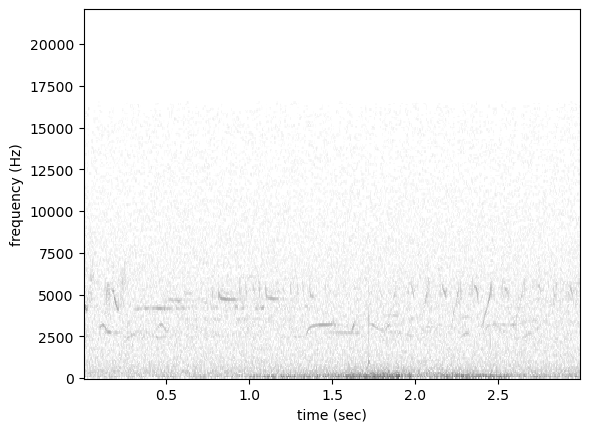

In [20]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [21]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

In [22]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

In [23]:
model.optimizer_params['lr'] = learning_rate


In [24]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [25]:
class_list

['target_presence']

In [26]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


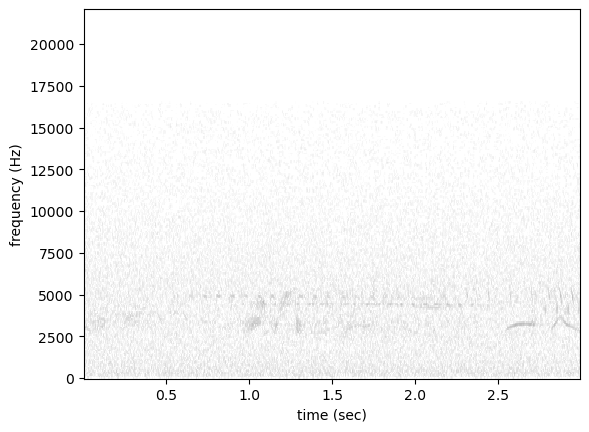

In [27]:
show_sample_from_df(present=True)


In [28]:
print(f'model.device is: {model.device}')

model.device is: mps


In [29]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [30]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [31]:
shuffled_balanced_valid_df.value_counts()

target_presence
0.0                500
1.0                500
Name: count, dtype: int64

In [32]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 [batch 0/50, 0.00%] 
	DistLoss: 0.724
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.518

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

dyld[14242]: Assertion failed: (this->magic == kMagic), function matchesPath, file Loader.cpp, line 154.



RuntimeError: DataLoader worker (pid(s) 14242) exited unexpectedly

In [ ]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = 10,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 [batch 0/25, 0.00%] 
	DistLoss: 0.502
Metrics:
Metrics:
	MAP: 0.855

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.886

Training Epoch 11


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 [batch 0/25, 0.00%] 
	DistLoss: 0.493
Metrics:
Metrics:
	MAP: 0.871

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.887

Training Epoch 12


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 [batch 0/25, 0.00%] 
	DistLoss: 0.538
Metrics:
Metrics:
	MAP: 0.872

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.896

Training Epoch 13


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 [batch 0/25, 0.00%] 
	DistLoss: 0.439
Metrics:
Metrics:
	MAP: 0.878

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.899

Training Epoch 14


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 [batch 0/25, 0.00%] 
	DistLoss: 0.454
Metrics:
Metrics:
	MAP: 0.880

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.897

Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.414
Metrics:
Metrics:
	MAP: 0.891

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.903

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.358
Metrics:
Metrics:
	MAP: 0.887

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.909

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 [batch 0/25, 0.00%] 
	DistLoss: 0.507
Metrics:
Metrics:
	MAP: 0.895

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.911

Training Epoch 18


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 [batch 0/25, 0.00%] 
	DistLoss: 0.478
Metrics:
Metrics:
	MAP: 0.889

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.915

Training Epoch 19


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 [batch 0/25, 0.00%] 
	DistLoss: 0.479
Metrics:
Metrics:
	MAP: 0.894

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.914

Best Model Appears at Epoch 18 with Validation score 0.915.


# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [ ]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_ts_shuffled_single_neuron{dt}")

# Show metrics

In [ ]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.5936640000000001,
   'avg_precision': 0.5879460977304021,
   'precision': 0.5416666666666666,
   'recall': 0.728,
   'f1': 0.6211604095563139,
   'support': 500},
  'precision': 0.5635162601626016,
  'recall': 0.556,
  'f1': 0.5424642627491714,
  'jaccard': 0.37619092097889034,
  'hamming_loss': 0.444,
  'map': 0.5879460977304021,
  'au_roc': 0.5936640000000001},
 1: {'target_presence': {'au_roc': 0.586496,
   'avg_precision': 0.5727208041688819,
   'precision': 0.5112299465240642,
   'recall': 0.956,
   'f1': 0.6662020905923345,
   'support': 500},
  'precision': 0.5863842040312628,
  'recall': 0.521,
  'f1': 0.4092072399864327,
  'jaccard': 0.29092650644374785,
  'hamming_loss': 0.479,
  'map': 0.5727208041688819,
  'au_roc': 0.586496},
 2: {'target_presence': {'au_roc': 0.62778,
   'avg_precision': 0.6186220711409831,
   'precision': 0.5490956072351422,
   'recall': 0.85,
   'f1': 0.6671899529042387,
   'support': 500},
  'precision': 0.608618600

In [ ]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.5172734375,
   'avg_precision': 0.5159681180718687,
   'precision': 0.5030425963488844,
   'recall': 0.93,
   'f1': 0.652917946467749,
   'support': 800},
  'precision': 0.5201163394967563,
  'recall': 0.505625,
  'f1': 0.39703443468881483,
  'jaccard': 0.28031256659259035,
  'hamming_loss': 0.494375,
  'map': 0.5159681180718687,
  'au_roc': 0.5172734375},
 1: {'target_presence': {'au_roc': 0.5388343750000001,
   'avg_precision': 0.5205410307115994,
   'precision': 0.5050287356321839,
   'recall': 0.87875,
   'f1': 0.6414233576642335,
   'support': 800},
  'precision': 0.5193412908930151,
  'recall': 0.50875,
  'f1': 0.4308307264511644,
  'jaccard': 0.29793738249953394,
  'hamming_loss': 0.49125,
  'map': 0.5205410307115994,
  'au_roc': 0.5388343750000001},
 2: {'target_presence': {'au_roc': 0.5553671875,
   'avg_precision': 0.5557425840270676,
   'precision': 0.5131298793470547,
   'recall': 0.90375,
   'f1': 0.6545948392937981,
   'support': 800},

Here we can see how the opso resample operation leaves the dataframe sorted into classes, so suffling is a necessary next step. 

In [ ]:
pd.concat([balanced_train_df.tail(), balanced_train_df.head()])

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-255454.mp3,3.0,6.0,1.0
../../data/raw/recordings/OSFL/recording-4503.mp3,133.5,136.5,1.0
../../data/raw/recordings/OSFL/recording-292106.mp3,234.0,237.0,1.0
../../data/raw/recordings/OSFL/recording-622593.flac,3.0,6.0,1.0
../../data/raw/recordings/OSFL/recording-104311.mp3,64.5,67.5,1.0
../../data/raw/recordings/OSFL/recording-315773.mp3,178.5,181.5,0.0
../../data/raw/recordings/OSFL/recording-296638.mp3,28.5,31.5,0.0
../../data/raw/recordings/OSFL/recording-622379.flac,150.0,153.0,0.0
../../data/raw/recordings/OSFL/recording-291890.mp3,232.5,235.5,0.0


In [ ]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

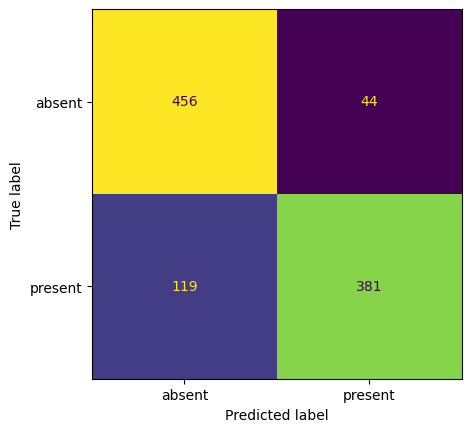

In [ ]:
shuf_preds = model.predict(shuffled_balanced_valid_df)
shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
scores = shuf_preds.sigmoid_prediction.values
targets = shuffled_balanced_valid_df.target_presence.values
cm = opso.metrics.M.confusion_matrix(targets, scores.round())
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
cm_display.plot(colorbar=False)

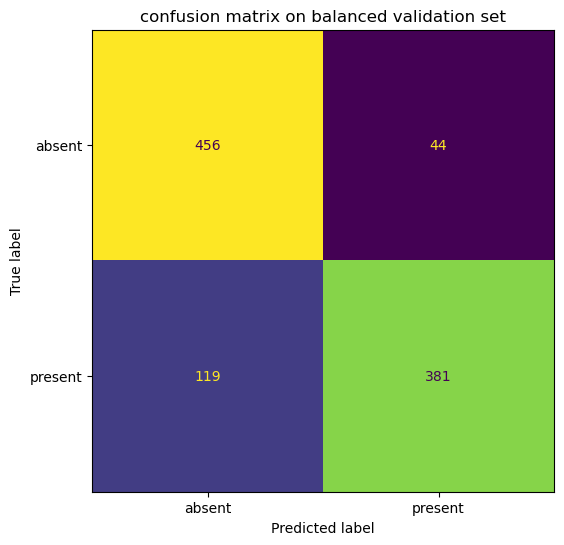

In [ ]:
# Plot the confusion matrix and log it to wandb
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("confusion matrix on balanced validation set")
cm_display.plot(ax=ax, colorbar=False)
wandb.log({"Balanced classes confusion matrix": wandb.Image(fig)})

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10990 [00:00<?, ?it/s]

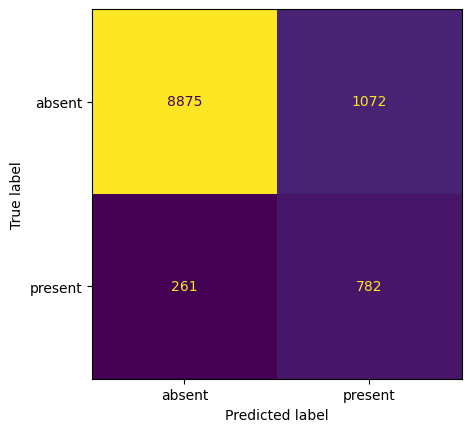

In [ ]:
valid_preds = model.predict(valid_df)
valid_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(valid_preds.target_presence.values))
scores = valid_preds.sigmoid_prediction.values
targets = valid_df.target_presence.values
cm = opso.metrics.M.confusion_matrix(targets, scores.round())
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
cm_display.plot(colorbar=False)

In [ ]:
model.classes

['target_presence']

# Result: 

This proves that the model can make good predictions with a single output neuron. 

# Train the model further
This time with a shuffled training set. 

In [ ]:
# model.train(
#     shuffled_balanced_train_df,
#     shuffled_balanced_valid_df,
#     epochs = epochs,
#     batch_size = 64,
#     num_workers = 4, #4 parallelized cpu tasks for preprocessing
#     log_interval = 100,
#     save_interval = 10,
#     wandb_session = wandb_session,
#     )

In [ ]:
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [ ]:
# predictions = best_model.predict(valid_df)
# cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(predictions, 1)))

# cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=best_model.classes)
# # Plot the confusion matrix
# fig, ax = plt.subplots(figsize=(6, 6))
# # add a title
# ax.set_title("Confusion matrix on full validation set")
# cm_display.plot(ax=ax, colorbar=False)


In [ ]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
loss,███▇▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,9
loss,0.43463
